In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
#read the data
data = pd.read_csv("/content/dengue_cases_only.csv")
data.head()

,state_ut,district,Disease,Cases,Deaths,day,mon,year,Latitude,Longitude,preci,LAI,Temp
0,Telangana,Nalgonda,Dengue,6,0,11,3,2022,16.857964,79.217494,0.000134,8,309.556
1,Kerala,Trivandrum,Dengue,9,0,22,2,2022,8.488227,76.947551,0.093704,46,301.496
2,Tamil Nadu,Ariyalur,Dengue,6,0,5,2,2022,11.076036,79.117455,0.012509,10,303.384
3,Tamil Nadu,Virudhunagar,Dengue,17,0,16,2,2022,9.520894,77.878456,0.307975,7,306.000
4,Maharashtra,Raigad,Dengue,11,0,21,3,2022,18.492809,73.138071,0.000180,0,312.184


In [ ]:
df = data[['state_ut', 'district', 'day', 'mon','year', 'Temp', 'preci', 'LAI', 'Cases']].copy() #dropping the irrelevant data

In [ ]:
df.columns #showing columns

Index(['state_ut', 'district', 'day', 'mon', 'year', 'Temp', 'preci', 'LAI',
       'Cases'],
      dtype='object')

In [ ]:
df.shape #showing number of rows and columns

(1698, 9)

In [ ]:
df.info() #checking for null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1698 entries, 0 to 1697
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   state_ut  1698 non-null   object 
 1   district  1698 non-null   object 
 2   day       1698 non-null   int64  
 3   mon       1698 non-null   int64  
 4   year      1698 non-null   int64  
 5   Temp      1698 non-null   float64
 6   preci     1698 non-null   float64
 7   LAI       1698 non-null   int64  
 8   Cases     1698 non-null   object 
dtypes: float64(2), int64(4), object(3)
memory usage: 119.5+ KB


In [ ]:
df.head() #top 5 rows

,state_ut,district,day,mon,year,Temp,preci,LAI,Cases
0,Telangana,Nalgonda,11,3,2022,309.556,0.000134,8,6
1,Kerala,Trivandrum,22,2,2022,301.496,0.093704,46,9
2,Tamil Nadu,Ariyalur,5,2,2022,303.384,0.012509,10,6
3,Tamil Nadu,Virudhunagar,16,2,2022,306.000,0.307975,7,17
4,Maharashtra,Raigad,21,3,2022,312.184,0.000180,0,11


In [ ]:
df.loc[:,'Cases'] = pd.to_numeric(df['Cases'], errors='coerce')
df = df.dropna(subset=['Cases'])
df['Cases'] = df['Cases'].astype(int)
print(df['Cases'].dtype)     #changing the values of cases into int and dropping the null values

int64


In [ ]:
df.info() #checking for the null values

<class 'pandas.core.frame.DataFrame'>
Index: 1697 entries, 0 to 1697
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   state_ut  1697 non-null   object 
 1   district  1697 non-null   object 
 2   day       1697 non-null   int64  
 3   mon       1697 non-null   int64  
 4   year      1697 non-null   int64  
 5   Temp      1697 non-null   float64
 6   preci     1697 non-null   float64
 7   LAI       1697 non-null   int64  
 8   Cases     1697 non-null   int64  
dtypes: float64(2), int64(5), object(2)
memory usage: 132.6+ KB


In [ ]:
df_raw = df.copy()  #creating copy of dataset

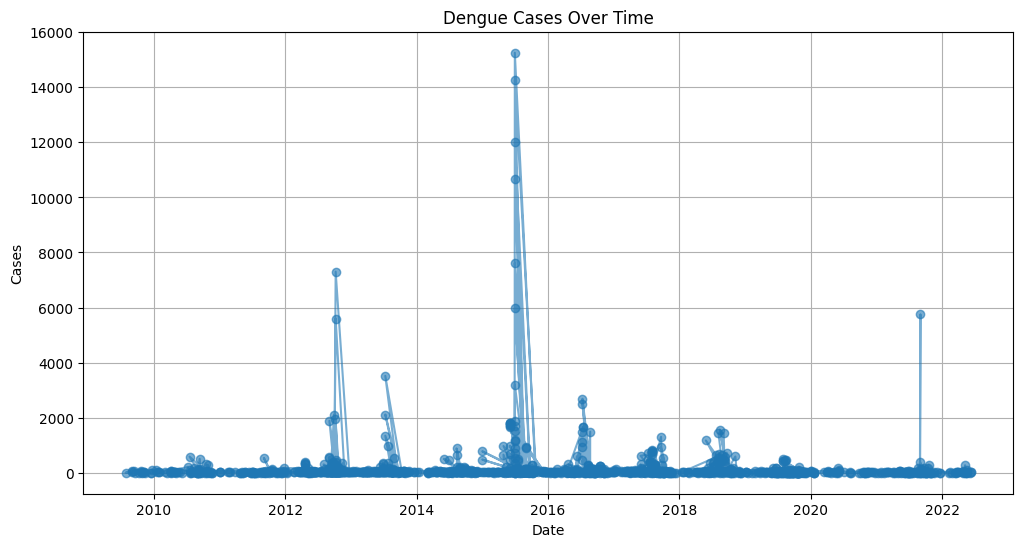

In [ ]:
import matplotlib.pyplot as plt
import datetime

df_raw['date'] = pd.to_datetime({
    'year': df_raw['year'],
    'month': df_raw['mon'],   # use 'mon' as month
    'day': df_raw['day']
})
plt.figure(figsize=(12,6))
plt.plot(df_raw['date'], df_raw['Cases'], marker='o', linestyle='-', alpha=0.6)
plt.title('Dengue Cases Over Time')
plt.xlabel('Date')
plt.ylabel('Cases')
plt.grid(True)
plt.show()   #visualizing the data, plotting the uncertainity of the data


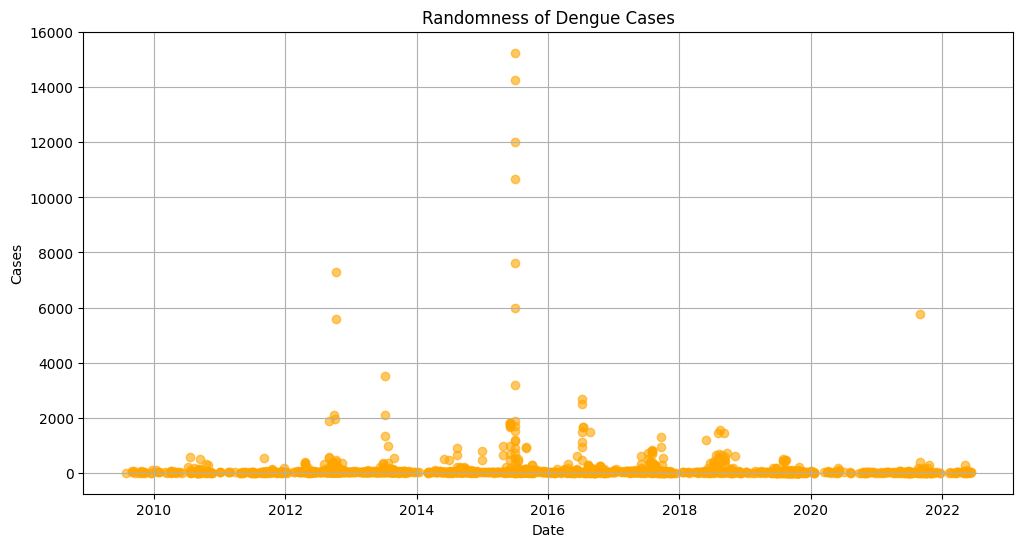

In [ ]:
plt.figure(figsize=(12,6))
plt.scatter(df_raw['date'], df_raw['Cases'], alpha=0.6, color='orange')
plt.title('Randomness of Dengue Cases')
plt.xlabel('Date')
plt.ylabel('Cases')
plt.grid(True)        #as the data containes huge outliers we will be using the past data of specific district and then we will predict
plt.show()


In [ ]:
df_enc = df.sort_values(['state_ut','district','year','mon', 'day']).reset_index(drop=True)
df_enc.head()  #sort the columns as per given columns

,state_ut,district,day,mon,year,Temp,preci,LAI,Cases
0,Andhra Pradesh,Chittoor,4,3,2017,306.120,0.000270,8,63
1,Andhra Pradesh,Kadapa,17,5,2014,316.036,0.000117,0,15
2,Andhra Pradesh,Kadapa,10,3,2015,311.190,0.043336,6,42
3,Andhra Pradesh,Kadapa,1,7,2019,313.940,0.283527,3,6
4,Andhra Pradesh,Krishna,31,8,2011,300.820,0.572981,9,45


In [ ]:
df['cases_lag1'] = df.groupby(['state_ut', 'district'])['Cases'].shift(1).fillna(0)
df['cases_ma7'] = df.groupby(['state_ut', 'district'])['Cases'].rolling(7, min_periods=1).mean().reset_index(level=[0,1], drop=True)
df['Cases_ma14'] = df.groupby(['state_ut','district'])['Cases'].rolling(14, min_periods=1).mean().reset_index(level=[0,1], drop=True)
df['Cases_lag7'] = df.groupby(['state_ut','district'])['Cases'].shift(7).fillna(0)    #creating the previous logs

In [ ]:
df_enc = pd.get_dummies(df, columns=['state_ut', 'district'], drop_first=True)      #creating dummy classes for each state and their respective district

In [ ]:
df_enc.head()         #printing first 5 rows of encoded dataset

,day,mon,year,Temp,preci,LAI,Cases,cases_lag1,cases_ma7,Cases_ma14,...,district_Visakhapatnam,district_Wanaparthy,district_Warangal,district_Wardha,district_Washim,district_Wayanad,district_West Garo Hills,district_West Godavari,district_West Siang,district_thiruvananthapuram
0,11,3,2022,309.556,0.000134,8,6,0.0,6.0,6.0,...,False,False,False,False,False,False,False,False,False,False
1,22,2,2022,301.496,0.093704,46,9,0.0,9.0,9.0,...,False,False,False,False,False,False,False,False,False,False
2,5,2,2022,303.384,0.012509,10,6,0.0,6.0,6.0,...,False,False,False,False,False,False,False,False,False,False
3,16,2,2022,306.000,0.307975,7,17,0.0,17.0,17.0,...,False,False,False,False,False,False,False,False,False,False
4,21,3,2022,312.184,0.000180,0,11,0.0,11.0,11.0,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
num_cols = ['day','mon', 'year', 'Temp', 'preci', 'LAI', 'cases_lag1', 'Cases_lag7', 'cases_ma7', 'Cases_ma14']
scaler = StandardScaler()
df_enc[num_cols] = scaler.fit_transform(df_enc[num_cols])      #Scalling the numeric values

In [ ]:
last_year = df_enc['year'].max()                #manually spliting the dataset into training and testing dataset
train = df_enc[df_enc['year'] < last_year]
test  = df_enc[df_enc['year'] == last_year]

x_train = train.drop('Cases', axis=1)
y_train = train['Cases']

x_test = test.drop('Cases', axis=1)
y_test = test['Cases']

In [ ]:
x_train.columns

Index(['day', 'mon', 'year', 'Temp', 'preci', 'LAI', 'cases_lag1', 'cases_ma7',
       'Cases_ma14', 'Cases_lag7',
       ...
       'district_Visakhapatnam', 'district_Wanaparthy', 'district_Warangal',
       'district_Wardha', 'district_Washim', 'district_Wayanad',
       'district_West Garo Hills', 'district_West Godavari',
       'district_West Siang', 'district_thiruvananthapuram'],
      dtype='object', length=387)

In [ ]:
x_train.head()

,day,mon,year,Temp,preci,LAI,cases_lag1,cases_ma7,Cases_ma14,Cases_lag7,...,district_Visakhapatnam,district_Wanaparthy,district_Warangal,district_Wardha,district_Washim,district_Wayanad,district_West Garo Hills,district_West Godavari,district_West Siang,district_thiruvananthapuram
23,-0.453028,-2.377449,1.75665,0.266875,0.653662,-0.158018,-0.164524,-0.216270,-0.263515,-0.149733,...,False,False,False,False,False,False,False,False,False,False
24,1.104800,-2.377449,1.75665,0.264943,-0.632666,-0.972155,-0.156558,-0.210293,-0.255015,-0.149733,...,False,False,False,False,False,False,False,False,False,False
25,1.104800,-2.377449,1.75665,0.278926,-0.590310,-0.972155,-0.164524,-0.214563,-0.261087,-0.149733,...,False,False,False,False,False,False,False,False,False,False
26,-0.675574,-2.003188,1.75665,0.342817,-0.726777,-0.972155,-0.164524,-0.221394,-0.270801,-0.149733,...,False,False,False,False,False,False,False,False,False,False
27,0.103339,-2.003188,1.75665,0.354488,-0.726831,-0.361552,-0.164524,-0.194070,-0.231944,-0.149733,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
#Importing the XGB Regressor and training the model
model = XGBRegressor(n_estimators=200, learning_rate=0.1, random_state=42, objective='reg:squarederror')
model.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
def get_past_cases(df_raw, state_ut, district, year, mon, day, window=14):
    temp_df = df_raw[(df_raw['state_ut']==state_ut) & (df_raw['district']==district)]
    temp_df = temp_df[(temp_df['year'] < year) | ((temp_df['year']==year) & ((temp_df['mon'] < mon) | ((temp_df['mon']==mon) & (temp_df['day']<day))))]
    last_cases = temp_df.sort_values(['year','mon','day'])['Cases'].tolist()[-window:]

    if len(last_cases) < window:
      last_cases = [0]*(window - len(last_cases)) + last_cases
    return last_cases #the main motive behind this function is to get past cases that is previous days and weeks and moving average of previous 7 days an 14 days

In [ ]:
def pred_dengue(model, x_train, day, mon, year, Temp, preci, LAI, past_cases=None, state_ut=None, district = None):

  if past_cases is None:        #fetching the past cases
      past_cases = get_past_cases(df_raw, state_ut, district, year, mon, day)

  input_df = pd.DataFrame([{      #forming the dataset
        'day': day,
        'mon': mon,
        'year': year,
        'Temp': Temp,
        'preci': preci,
        'LAI': LAI,
        'cases_lag1': past_cases[-1],
        'cases_lag7': past_cases[-7],
        'cases_ma7': np.mean(past_cases[-7:]),
        'Cases_ma14': np.mean(past_cases[-14:])
    }])

  missing_cols = [col for col in x_train.columns if col not in input_df.columns]    #filling the dataset with the columns which are needed by the model and in theta columns insert value 0
  if missing_cols:
    input_df = pd.concat([input_df, pd.DataFrame(0, index=input_df.index, columns=missing_cols)], axis=1)


  if state_ut and f'state_ut_{state_ut}' in input_df.columns:         #identify the state and district user has given and give the value 1 to that column which can be easily recognized by the model
        input_df[f'state_ut_{state_ut}'] = 1
  if district and f'district_{district}' in input_df.columns:
        input_df[f'district_{district}'] = 1

  input_df = input_df.reindex(columns=x_train.columns, fill_value=0)

  lag_cols = ['cases_lag1','Cases_lag7','cases_ma7','Cases_ma14']       #scalling the values of new dataset given by the user
  all_num_cols = ['day','mon', 'year', 'Temp', 'preci', 'LAI'] + lag_cols
  input_df[all_num_cols] = scaler.transform(input_df[all_num_cols])

  pred_cases = model.predict(input_df)[0]
  return pred_cases       #run the prediction

y_pred_test = model.predict(x_test)               #this is used for checking the metrics of the model
mae = mean_absolute_error(y_test, y_pred_test)
mse = mean_squared_error(y_test, y_pred_test)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_test)
print (f"MAE  : {mae:.2f}")
print (f"MSE  : {mse:.2f}")
print (f"RMSE : {rmse:.2f}")
print (f"R²   : {r2:.2f}")

MAE  : 5.41
MSE  : 148.92
RMSE : 12.20
R²   : 0.95


In [ ]:

print("Enter input values to predict dengue cases:") #Take the input from the user

day = int(input("Day of month (1–31): "))
month = int(input("Month (1–12): "))
year = int(input("Year: "))

Temp = float(input("Temperature: "))
preci = float(input("Precipitation: "))
LAI = float(input("LAI (vegetation index): "))

state_ut = input("State : ").strip()
district = input("District : ").strip()

past_cases_input = input("Last 14 days of cases (optional, comma separated): ")
past_cases = [int(x) for x in past_cases_input.split(",")] if past_cases_input else None


pred_cases = pred_dengue(
    model=model,
    x_train=x_train,
    day=day,
    mon=month,
    year=year,
    Temp=Temp,
    preci=preci,
    LAI=LAI,
    past_cases=past_cases,
    state_ut=state_ut if state_ut != "" else None,
    district=district if district != "" else None
)

print(f"\nPredicted Dengue Cases: {pred_cases:.0f}")

Enter input values to predict dengue cases:
Day of month (1–31): 10
Month (1–12): 10
Year: 2025
Temperature: 303
Precipitation: 0.012
LAI (vegetation index): 9
State : Maharashtra
District : Pune
Last 14 days of cases (optional, comma separated): 

Predicted Dengue Cases: 12
